In [3]:
# Standard imports
import numpy as np
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
import sys
import yaml
import json
from typing import List, Union

# Deep learning imports.
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset

import torchvision
import torchvision.transforms.functional as TF
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou, nms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics

from modeling import CRES_Dataset, CRES_DM, CRES_LM
root_dir = sys.path[0]+'/config/fasterRCNN'

## Loading saved model

In [4]:
PATH = 'tb_logs/cres/version_{}/checkpoints/epoch={:02d}.ckpt'.format(56, 96)
cres_lm = CRES_LM.load_from_checkpoint(PATH)

In [6]:
# Define training object, max_pool=16, file_max=1000, batch_size=1 correspond to 
# the conditions for the model 56 inside of tb_logs
cres_dm = CRES_DM(root_dir,
                  max_pool=16,
                  file_max=1000,
                  batch_size=1,
                  num_workers=4
                  )

#### Generate some predictions

In [7]:
test_dataiter = iter(cres_dm.test_dataloader())
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)
preds

[{'boxes': tensor([[146.5394, 160.3418, 319.6300, 167.0255],
          [171.9239, 118.2621, 319.6597, 124.9091],
          [204.2013, 144.0251, 319.3449, 146.0231],
          [ 55.0153, 249.9287, 248.4135, 252.0918],
          [297.8691, 189.0088, 319.7892, 190.0078]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1]),
  'scores': tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9995], grad_fn=<IndexBackward0>)}]

#### Visualize

In [10]:
def apply_score_cut(preds, score_threshold=0.5):
    """
    Takes a list of prediction dictionaries (one for each image) and cuts
    out all instances whose score is below the score threshold.

    Args:
        preds (List[Dict[torch.Tensor]]): predictions as output by the
            torchvision implimentation of MaskRCNN or FasterRCNN. The 
            scores are in the range (0,1) and signify the certainty of 
            the model for that instance.
            See link below for details on the target/prediction formatting.
            https://pytorch.org/vision/0.12/_modules/torchvision/models/detection/mask_rcnn.html
        score_threshold (float): the threshold to apply to the identified
            objects. If an instance is below the score_threshold it will
            be removed from the score_thresholded_preds dictionary.

    Returns:
        score_thresholded_preds (List[Dict[torch.Tensor]]): predictions
            that exceed score_threshold.
    """
    score_thresholded_preds = [
        {key: value[pred["scores"] > score_threshold] for key, value in pred.items()}
        for pred in preds
    ]

    return score_thresholded_preds

def show(imgs, figsize=(10.0, 10.0)):
    """Displays a single image or list of images. Taken more or less from
    the pytorch docs:
    https://pytorch.org/vision/main/auto_examples/plot_visualization_utils.html#visualizing-a-grid-of-images

    Args:
        imgs (Union[List[torch.Tensor], torch.Tensor]): A list of images
            of shape (3, H, W) or a single image of shape (3, H, W).
        figsize (Tuple[float, float]): size of figure to display.

    Returns:
        None
    """

    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), figsize=figsize, squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

    return None

def display_boxes(imgs, target_pred_dict, class_map, width = 1, fill=False):
    """
    Takes a list of images and a list of target or prediction dictionaries
    of the same len and overlays bounding boxes onto the images.
    Returns:
        result_imgs (List[torch.ByteTensor[3, H, W]]): list of images with
            overlaid bounding boxes.
    """
    num_imgs = len(imgs)
    result_imgs = [
        draw_bounding_boxes(
            imgs[i].type(torch.uint8),
            target_pred_dict[i]["boxes"].int(),
            fill=fill,
            colors=[
                class_map[j.item()]["target_color"]
                for j in target_pred_dict[i]["labels"]
            ],
            width=width,
        )
        for i in range(num_imgs)
    ]

    return result_imgs

In [15]:
%matplotlib widget
@interact
def vizualize_targets_predictions(
                                target_box = widgets.Checkbox(value=False,description='target boxes'),
                                pred_box = widgets.Checkbox(value=False,description='prediction boxes'),
                                num_imgs= widgets.IntSlider(value=len(preds),min=0,max=len(preds),step=1, description = "num_imgs"),
                                score_thresh = widgets.FloatSlider(value=.5,min=0,max=1,step=.0001, description = "score_thresh"),
                                width =  widgets.IntSlider(value=1,min=1,max=10,step=1), 
                                display_size = widgets.IntSlider(value=10,min=2,max=50,step=1)
                                ): 
    preds_cut = apply_score_cut(preds, score_threshold=score_thresh)
    result_image = [imgs[i] for i in range(num_imgs)]

    if target_box: 
        result_image = display_boxes(result_image, targets, cres_dm.class_map, fill = True)

    if pred_box: 
        result_image = display_boxes(result_image, preds_cut, cres_dm.class_map)

    grid = make_grid(result_image)
    show(grid, figsize = (display_size, display_size))

interactive(children=(Checkbox(value=False, description='target boxes'), Checkbox(value=False, description='pr…

#### Rerun this cell in order to generate new image above.

In [14]:
imgs, targets = test_dataiter.next()
preds = cres_lm(imgs)

In [97]:
keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=.1)
print(preds[0]['boxes'][keep], preds[0]['scores'][keep], preds[0]['labels'][keep])
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])
box_iou(torch.tensor([ 80.4676,  89.0107, 132.5562,  89.9598]).unsqueeze(0),torch.tensor([ 80.1276,  89.9913, 132.9292,  91.0066]).unsqueeze(0))

tensor([[218.2170, 100.1417, 319.6119, 104.1351],
        [ 16.0008, 196.2398, 164.2518, 200.6967],
        [115.0901,  96.1346, 319.4814,  98.5394],
        [ 80.4676,  89.0107, 132.5562,  89.9598],
        [ 80.1276,  89.9913, 132.9292,  91.0066]], grad_fn=<IndexBackward0>) tensor([1.0000, 1.0000, 0.9990, 0.7828, 0.5706], grad_fn=<IndexBackward0>) tensor([1, 1, 1, 1, 1])


tensor([[0.]])

In [134]:
targets[0]['boxes'],preds[0]['boxes'][keep]

(tensor([[ 14, 196, 165, 200],
         [115,  97, 320,  99],
         [ 80,  89, 132,  90],
         [218, 100, 320, 104]], dtype=torch.int32),
 tensor([[218.2170, 100.1417, 319.6119, 104.1351],
         [ 16.0008, 196.2398, 164.2518, 200.6967],
         [115.0901,  96.1346, 319.4814,  98.5394],
         [ 80.4676,  89.0107, 132.5562,  89.9598],
         [ 80.1276,  89.9913, 132.9292,  91.0066]], grad_fn=<IndexBackward0>))

In [133]:
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])

tensor([[0.0000, 0.7882, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5361, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.9311, 0.0043],
        [0.9277, 0.0000, 0.0000, 0.0000, 0.0000]], grad_fn=<DivBackward0>)

In [60]:
targets[0], apply_score_cut(preds)[0]

({'boxes': tensor([[ 14, 196, 165, 200],
          [115,  97, 320,  99],
          [ 80,  89, 132,  90],
          [218, 100, 320, 104]], dtype=torch.int32),
  'labels': tensor([1, 1, 1, 1])},
 {'boxes': tensor([[218.2170, 100.1417, 319.6119, 104.1351],
          [ 16.0008, 196.2398, 164.2518, 200.6967],
          [115.0901,  96.1346, 319.4814,  98.5394],
          [ 80.4676,  89.0107, 132.5562,  89.9598],
          [111.8717,  96.3601, 318.5783, 101.3533],
          [ 80.1276,  89.9913, 132.9292,  91.0066]], grad_fn=<IndexBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1]),
  'scores': tensor([1.0000, 1.0000, 0.9990, 0.7828, 0.6589, 0.5706],
         grad_fn=<IndexBackward0>)})

In [128]:
box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])[box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0]

tensor([0.7882, 0.5361, 0.9311, 0.0043, 0.9277], grad_fn=<IndexBackward0>)

In [32]:
ious = []
test_dataiter = iter(cres_dm.test_dataloader())

iterating = True
i=0

while iterating:
    try:
        imgs, targets = test_dataiter.next()
        preds = cres_lm(imgs)
        keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=.1)
        ious += list(box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])[box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0])
        if not i%25:
            print(f'On image {i}')
        i+=1
    except:
        iterating = False

On image 0
On image 25
On image 50
On image 75
On image 100


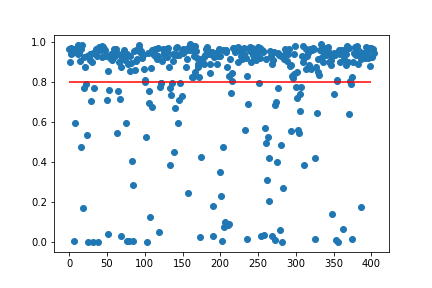

In [39]:
%matplotlib widget
ious = torch.detach(torch.tensor(ious)).numpy()
plt.scatter(list(range(len(ious))), ious)
plt.hlines(y=ious.mean(),xmin=0, xmax=400, color='red')
plt.show()

In [34]:
ious.mean().round(3)

0.8

In [35]:
ious_3 = []
test_dataiter = iter(cres_dm.test_dataloader())

iterating = True
i=0

while iterating:
    try:
        imgs, targets = test_dataiter.next()
        preds = cres_lm(imgs)
        keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=.3)
        ious_3 += list(box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])[box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0])
        if not i%25:
            print(f'On image {i}')
        i+=1
    except: 
        iterating = False

On image 0
On image 25
On image 50
On image 75
On image 100


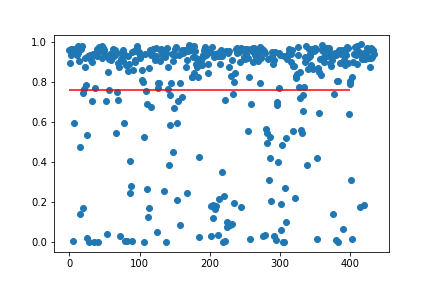

In [36]:
%matplotlib widget
ious_3 = torch.detach(torch.tensor(ious_3)).numpy()
plt.scatter(list(range(len(ious_3))), ious_3)
plt.hlines(y=ious_3.mean(),xmin=0, xmax=400, color='red')
plt.show()

In [37]:
ious_3.mean()

0.763434

In [21]:
ious_5 = []
test_dataiter = iter(cres_dm.test_dataloader())

iterating = True
i=0

while iterating:
    try:
        imgs, targets = test_dataiter.next()
        preds = cres_lm(imgs)
        keep = nms(preds[0]['boxes'], preds[0]['scores'], iou_threshold=.5)
        ious_5 += list(box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])[box_iou(targets[0]['boxes'], preds[0]['boxes'][keep])>0])
        if not i%25:
            print(f'On image {i}')
        i+=1
    except:
        iterating = False

On image 0
